In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import os
from tqdm.notebook import tqdm
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import *
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10492842934784621581
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10087235584
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12910898782765253150
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


In [23]:
!pip install tensorflow-addons

In [4]:
#needed for DNN 
import tensorflow as tf
# import tensorflow_addons as tfa
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2,l1
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM,GRU,Bidirectional
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
# from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
# from sklearn.metrics import average_precision_score,roc_auc_score, roc_curve, precision_recall_curve
# from sklearn.preprocessing import LabelEncoder
# from tensorflow.keras.preprocessing.text import Tokenizer
# from sklearn.utils import shuffle

In [5]:
PATH = '/Ml files/drug review SA'

In [6]:
df = pd.read_csv(PATH + '/data/results/clean_df.csv')
df = df.drop(['review','rating','vader_polarity', 'Review_Sentiment','blob_polarity', 'class_2' ], axis = 1)
df.head()

,cleaned_reviews,class
0,side effect take combination bystolic mg fish oil,neutral
1,son halfway fourth week intuniv become concern...,positve
2,use take another oral contraceptive pill cycle...,positve
3,first time use form birth control glad go patc...,positve
4,suboxone completely turn life around feel heal...,positve


In [7]:
# label encoding for output

sample_data = [2000,3000,100,2004,3080,4020]

def label_encoding(category,bool):
  le = preprocessing.LabelEncoder()
  le.fit(category)
  encoded_labels = le.transform(category)
  labels = np.array(encoded_labels) # Converting into numpy array
  class_names =le.classes_ ## Define the class names again
  if bool == True:
    print("\n\t\t\t Label Encoding ","\nClass Names:-->",le.classes_)
    for i in sample_data:
      print(category[i],' ', encoded_labels[i],'\n')
    return labels

labels = label_encoding(df['class'],True)


			 Label Encoding  
Class Names:--> ['negative' 'neutral' 'positve']
positve   2 

negative   0 

negative   0 

positve   2 

negative   0 

negative   0 



In [8]:
# set aside 20% of train and test data for evaluation
df.cleaned_reviews=df.cleaned_reviews.astype(str)

X = df.cleaned_reviews
Y = labels

def dataset_split(inputs, tags):

    X,X_test,y,y_test = train_test_split(inputs,tags,train_size = 0.8,
                                                  test_size = 0.2,random_state =42)
    X_train,X_valid,y_train,y_valid = train_test_split(X,y,train_size = 0.95,
                                                  test_size = 0.05,random_state =42)
    print("\nDataset Distribution:\n")
    print("\tSet Name","\t\tSize")
    print("\t========\t\t======")

    print("\tFull\t\t\t",len(inputs),
        "\n\tTraining\t\t",len(X_train),
        "\n\tTest\t\t\t",len(X_test),
        "\n\tValidation\t\t",len(X_valid))
  
    return X_train,X_valid,X_test,y_train,y_valid,y_test

X_train,X_valid,X_test,y_train,y_valid,y_test = dataset_split(X,Y)


Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 215063 
	Training		 163447 
	Test			 43013 
	Validation		 8603


In [9]:
# Train Data Tokenization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_length = 100
vocab_size = 43000  

tokenizer = Tokenizer(num_words = vocab_size, oov_token="<OOV>",filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'',lower=True)
tokenizer.fit_on_texts(X_train.values)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# Taining Data padding
train_sequences = tokenizer.texts_to_sequences(X_train.values)
train_padded = pad_sequences(train_sequences,padding='post', maxlen=max_length)

# Validation Data padding
validation_sequences = tokenizer.texts_to_sequences(X_valid.values)
validation_padded = pad_sequences(validation_sequences,padding='post', maxlen=max_length)

# testing data padding
test_sequences = tokenizer.texts_to_sequences(X_test.values)
test_padded = pad_sequences(test_sequences,padding='post',maxlen=max_length)

test_padded[0]

Found 41326 unique tokens.


array([ 1523, 34783,     1,   231,   741,     1,  3501,   295,   362,
         313,    14,   515,   160,   888,    27,  1437,   596,   399,
           8,  3856,   736,    36,     8,   844,    23,   977,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0])

In [10]:
def padded_infos(original,encoded,padded):
  print("\n\t\t\t Encoded Sequences ","\n")  
  print(original,"\n",encoded) 
  print("\n\t\t\t Paded Sequences \n",original,"\n",padded)

padded_infos(X_train[1],train_sequences[1],train_padded[1])


			 Encoded Sequences  

son halfway fourth week intuniv become concerned begin last week start take high dose two day could hardly get bed cranky sleep nearly hour drive home school vacation unusual call doctor monday morning say stick day see school get morning last two day problem free much agreeable ever less emotional good thing less cranky remembering thing overall behavior well try many different medication far effective 
 [128, 7, 1914, 60, 8, 8, 388, 73, 217, 328, 5, 1938, 1379, 70, 87, 18, 2754]

			 Paded Sequences 
 son halfway fourth week intuniv become concerned begin last week start take high dose two day could hardly get bed cranky sleep nearly hour drive home school vacation unusual call doctor monday morning say stick day see school get morning last two day problem free much agreeable ever less emotional good thing less cranky remembering thing overall behavior well try many different medication far effective 
 [ 128    7 1914   60    8    8  388   73  217  328    5 

In [11]:
#confusion matrix
def conf_matrix(y_pred):
  cm = confusion_matrix(y_test, y_pred) 

  cm_df = pd.DataFrame(cm,
                       index = ['negative', 'Neutral', 'Positive'], 
                       columns = ['negative', 'Neutral', 'Positive'])
  sns.set(font_scale=2) 
  plt.figure(figsize=(10,8))
  sns.heatmap(cm_df, annot=True,cmap="coolwarm", fmt='g')
  plt.ylabel('True label',fontsize=20)
  plt.xlabel('Predicted label',fontsize=20)
  plt.xticks( rotation=90, weight = 'bold')
  plt.yticks( rotation=0, weight = 'bold')
  plt.show()
  plt.close()

In [12]:
accuracy_threshold = 0.999
from tensorflow import keras
keras.backend.clear_session()
#callback function for early stopping
class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
#     if(logs.get('binary_accuracy') > ACCURACY_THRESHOLD):
      if(logs.get('accuracy')>accuracy_threshold):
        print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
        self.model.stop_training = True

acc_callback = myCallback()


In [13]:
embedding_dim=200
num_category = 3
epochs = 100
batch = 128
opt=RMSprop(0.001)


In [45]:
def Bidirectional_classifier_model(model_name,file_name,GRU_unit, epochs, batch, p_optimizer=opt , 
                                   p_loss:str = 'sparse_categorical_crossentropy', p_metrics:list = ['accuracy']):
    """
    Build a Bidirectional Models for classification
    """
    filepath = PATH +'/models/'+file_name
    reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss',  
                                    factor=0.5, patience=2, 
                                    verbose=1, mode='auto', 
                                    min_delta=0.001, cooldown=1, min_lr=0.00001)
    
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, 
                                             save_weights_only=False, mode='auto')
    
    callback_list = [acc_callback, checkpoint,reduceLROnPlat ]
    
    print('----------------------------- sequential_classifier_model -----------------------------')
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1]),
        tf.keras.layers.SpatialDropout1D(0.2),
        tf.keras.layers.Bidirectional(model_name(GRU_unit,return_sequences=True)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(num_category, activation='sigmoid')
])
    model.compile(optimizer=p_optimizer, loss = p_loss, metrics = p_metrics)
    model.summary()
    model_history = model.fit(train_padded, y_train, 
                    epochs=epochs,
                    batch_size = batch,
                    validation_data=(validation_padded, y_valid), 
                    verbose=1,
                    callbacks = callback_list)
    return model,model_history

In [46]:
# Bidirection GRU 
BiGRU_model, BiGRU_history = Bidirectional_classifier_model(model_name = GRU,
                                                            file_name = 'BiGRU.h5',
                                                            GRU_unit = 256,
                                                            epochs = epochs,
                                                            batch = batch)

----------------------------- sequential_classifier_model -----------------------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 200)          8600000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 100, 200)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 512)          703488    
_________________________________________________________________
dense (Dense)                (None, 100, 64)           32832     
_________________________________________________________________
dropout (Dropout)            (None, 100, 64)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 100, 32)           2080      
__________________________________


Epoch 00025: val_accuracy did not improve from 0.94316
Epoch 26/100
1277/1277 [==============================] - 69s 54ms/step - loss: 0.0151 - accuracy: 0.9960 - val_loss: 0.2141 - val_accuracy: 0.9408

Epoch 00026: val_accuracy did not improve from 0.94316
Epoch 27/100
1277/1277 [==============================] - 69s 54ms/step - loss: 0.0157 - accuracy: 0.9959 - val_loss: 0.2140 - val_accuracy: 0.9398

Epoch 00027: val_accuracy did not improve from 0.94316
Epoch 28/100
1277/1277 [==============================] - 69s 54ms/step - loss: 0.0153 - accuracy: 0.9959 - val_loss: 0.2203 - val_accuracy: 0.9372

Epoch 00028: val_accuracy did not improve from 0.94316
Epoch 29/100
1277/1277 [==============================] - 70s 55ms/step - loss: 0.0146 - accuracy: 0.9961 - val_loss: 0.2166 - val_accuracy: 0.9396

Epoch 00029: val_accuracy did not improve from 0.94316
Epoch 30/100
1277/1277 [==============================] - 65s 51ms/step - loss: 0.0145 - accuracy: 0.9963 - val_loss: 0.2191 - v


Epoch 00064: val_accuracy did not improve from 0.94560
Epoch 65/100
1277/1277 [==============================] - 75s 59ms/step - loss: 0.0118 - accuracy: 0.9970 - val_loss: 0.2451 - val_accuracy: 0.9423

Epoch 00065: val_accuracy did not improve from 0.94560
Epoch 66/100
1277/1277 [==============================] - 75s 59ms/step - loss: 0.0120 - accuracy: 0.9971 - val_loss: 0.2427 - val_accuracy: 0.9447

Epoch 00066: val_accuracy did not improve from 0.94560
Epoch 67/100
1277/1277 [==============================] - 75s 59ms/step - loss: 0.0118 - accuracy: 0.9973 - val_loss: 0.2444 - val_accuracy: 0.9440

Epoch 00067: val_accuracy did not improve from 0.94560
Epoch 68/100
1277/1277 [==============================] - 75s 59ms/step - loss: 0.0115 - accuracy: 0.9972 - val_loss: 0.2438 - val_accuracy: 0.9426

Epoch 00068: val_accuracy did not improve from 0.94560
Epoch 69/100
1277/1277 [==============================] - 75s 59ms/step - loss: 0.0123 - accuracy: 0.9971 - val_loss: 0.2461 - v

In [14]:
model_path = "/Ml files/drug review SA/models"

In [15]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

In [49]:
#make predictions

model = load_model(model_path+"/BiGRU.h5")
predictions = model.predict(test_padded)
y_pred = np.argmax(predictions, axis=1)
evaluation = model.evaluate(test_padded,y_test)
print('loss {}'.format(evaluation[0]))
print('Accuracy {}'.format(evaluation[1]))
print('Precision {}'.format(precision_score(y_test, y_pred , average="micro")))
print('Recall {}'.format(recall_score(y_test, y_pred , average="macro")))
print('f1 score {}'.format(f1_score(y_test, y_pred , average="micro")))



1345/1345 [==============================] - 27s 19ms/step - loss: 0.2658 - accuracy: 0.9509
loss 0.2657765746116638
Accuracy 0.9509218335151672
Precision 0.950921814335201
Recall 0.9409593470494841
f1 score 0.950921814335201


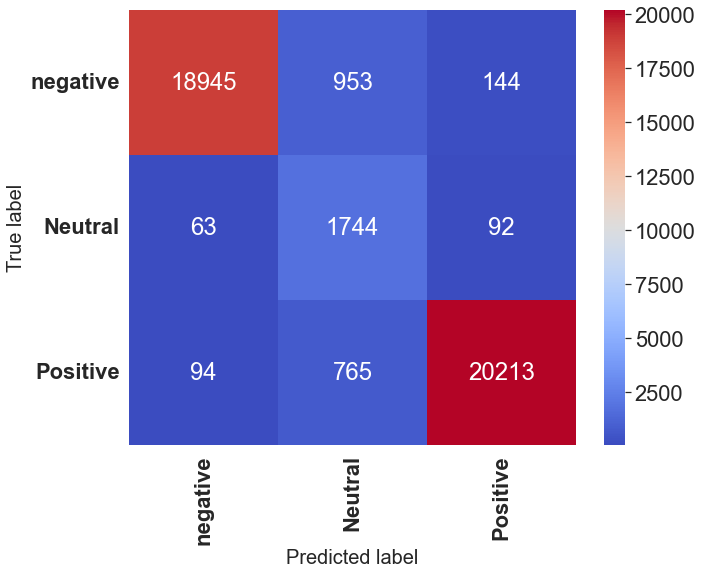

In [50]:
conf_matrix(y_pred)

In [20]:
#Report generation

def report_generate(pred,classifier):
  sns.set_style("whitegrid")
  report = pd.DataFrame(classification_report(y_true = y_test, y_pred =pred, output_dict=True)).transpose()
  report = report.rename(index={'0': 'negative','1':'Neutral','2':'Positive'})
  report[['precision','recall','f1-score']]=report[['precision','recall','f1-score']].apply(lambda x: round(x*100,2))
  report=report.drop(["support"],axis=1)
  columns = ['precision','recall','f1-score']
  report.columns = columns
  plt = report.plot(kind='bar',figsize=(12,6))
  plt.set_title('Multi-class Classification Report for '+str(classifier)+' .', fontsize=20)
  plt.tick_params(axis='x',rotation=30,labelsize=25)
  plt.tick_params(axis='y',rotation=0,labelsize=25)
  plt.legend(['precision', 'recall', 'f1-score'], loc=2,bbox_to_anchor = (1,1), prop={'size': 20})
  plt.grid('white')
  return plt,report

,precision,recall,f1-score
negative,99.18,94.53,96.80
Neutral,50.38,91.84,65.06
Positive,98.85,95.92,97.36
accuracy,95.09,95.09,95.09
macro avg,82.80,94.10,86.41
weighted avg,96.86,95.09,95.67


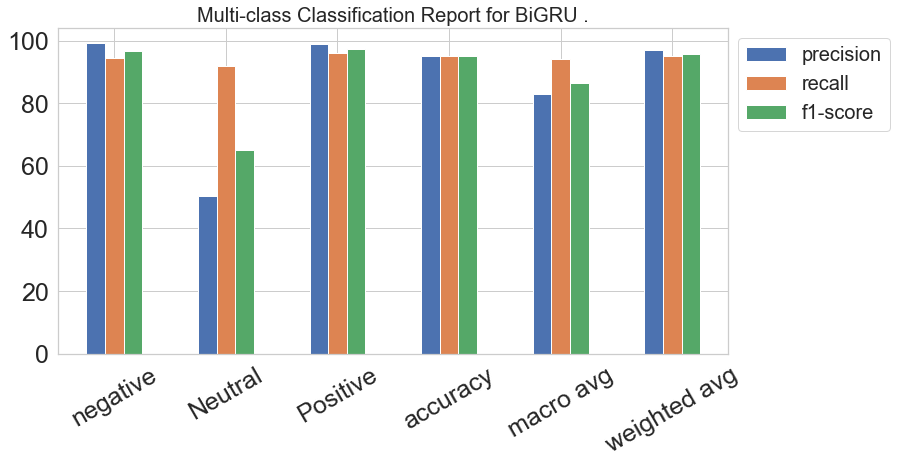

In [52]:
GRUreport=report_generate(y_pred,"BiGRU")
GRUreport[1]

In [21]:
def model_evaluate(history):
  sns.set_style("whitegrid")
  H = history.history
  fig = plt.figure(figsize = (30, 8))
  plt.subplot(121)
  plt.xlabel("number of epoch")
  plt.ylabel("Validation accuracy")
  plt.plot(H['accuracy'], label = 'training', marker='o', color='red', linewidth=3 )
  plt.plot(H['val_accuracy'], label = 'validation', marker='o', color='blue', linewidth=3 )
  plt.xticks( rotation=0, weight = 'bold', )
  plt.yticks( rotation=0, weight = 'bold')
  plt.tick_params(rotation=0,axis='y', labelsize=15)
  plt.tick_params(rotation=0,axis='x', labelsize=18)
  plt.grid('white')
  plt.legend()

  plt.subplot(122)
  plt.xlabel("number of epoch")
  plt.ylabel("Validation loss")
  plt.plot(H['loss'], label = 'training_loss', marker='o', color='red', linewidth=3 )
  plt.plot(H['val_loss'], label = 'validation_loss', marker='o', color='blue', linewidth=3 )
  plt.xticks( rotation=0, weight = 'bold', )
  plt.yticks( rotation=0, weight = 'bold')
  plt.tick_params(rotation=0,axis='y', labelsize=15)
  plt.tick_params(rotation=0,axis='x', labelsize=18)
  plt.grid('white')
  plt.legend()
    


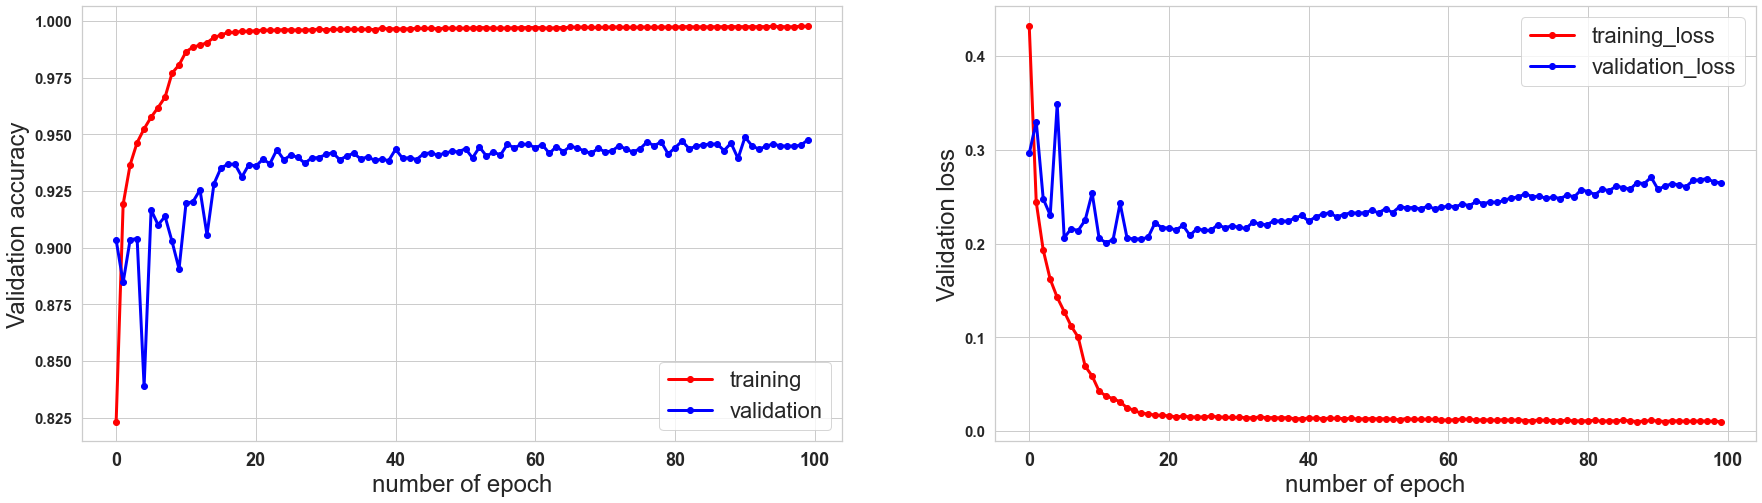

In [54]:
model_evaluate(BiGRU_history)

In [55]:
BiLSTM_model, BiLSTM_history = Bidirectional_classifier_model(model_name = LSTM,
                                                            file_name = 'BiLSTM.h5',
                                                            GRU_unit = 256,
                                                            epochs = epochs,
                                                            batch = batch)

----------------------------- sequential_classifier_model -----------------------------
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 200)          8600000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 100, 200)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 512)          935936    
_________________________________________________________________
dense_4 (Dense)              (None, 100, 64)           32832     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 64)           0         
_________________________________________________________________
dense_5 (Dense)              (None, 100, 32)           2080      
________________________________

1277/1277 [==============================] - 86s 67ms/step - loss: 0.2271 - accuracy: 0.9223 - val_loss: 0.2728 - val_accuracy: 0.9079

Epoch 00062: val_accuracy did not improve from 0.91154
Epoch 63/100
1277/1277 [==============================] - 87s 68ms/step - loss: 0.2266 - accuracy: 0.9230 - val_loss: 0.2690 - val_accuracy: 0.9076

Epoch 00063: val_accuracy did not improve from 0.91154
Epoch 64/100
1277/1277 [==============================] - 87s 68ms/step - loss: 0.2249 - accuracy: 0.9234 - val_loss: 0.2645 - val_accuracy: 0.9090

Epoch 00064: val_accuracy did not improve from 0.91154
Epoch 65/100
1277/1277 [==============================] - 86s 67ms/step - loss: 0.2245 - accuracy: 0.9231 - val_loss: 0.2705 - val_accuracy: 0.9078

Epoch 00065: val_accuracy did not improve from 0.91154
Epoch 66/100
1277/1277 [==============================] - 87s 68ms/step - loss: 0.2229 - accuracy: 0.9238 - val_loss: 0.2690 - val_accuracy: 0.9100

Epoch 00066: val_accuracy did not improve from 0

1277/1277 [==============================] - 83s 65ms/step - loss: 0.1791 - accuracy: 0.9373 - val_loss: 0.2243 - val_accuracy: 0.9187

Epoch 00100: val_accuracy improved from 0.91782 to 0.91875, saving model to /Ml files/drug review SA/models\BiLSTM.h5


In [56]:
#make predictions
model = load_model(model_path+"/BiLSTM.h5")
predictions = model.predict(test_padded)
y_pred = np.argmax(predictions, axis=1)
evaluation = model.evaluate(test_padded,y_test)
print('loss {}'.format(evaluation[0]))
print('Accuracy {}'.format(evaluation[1]))
print('Precision {}'.format(precision_score(y_test, y_pred , average="micro")))
print('Recall {}'.format(recall_score(y_test, y_pred , average="macro")))
print('f1 score {}'.format(f1_score(y_test, y_pred , average="micro")))



1345/1345 [==============================] - 30s 21ms/step - loss: 0.2196 - accuracy: 0.9230
loss 0.2195800542831421
Accuracy 0.9230000376701355
Precision 0.9230000232487853
Recall 0.8294103965336098
f1 score 0.9230000232487853


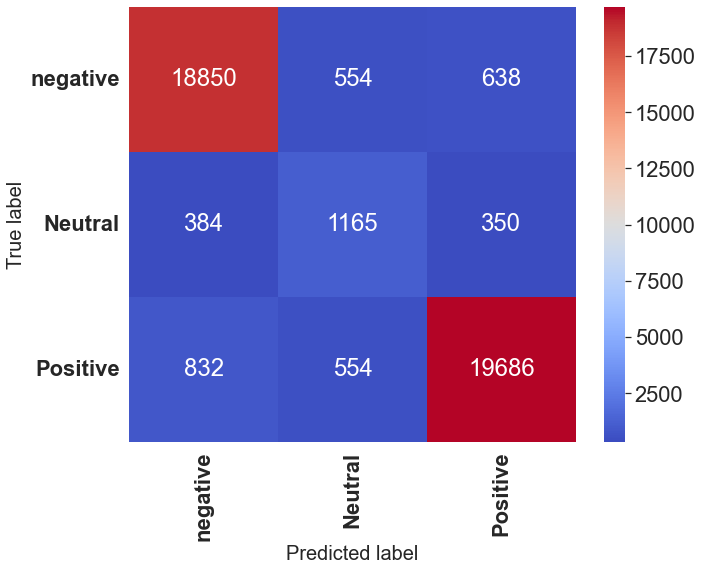

In [57]:
conf_matrix(y_pred)

,precision,recall,f1-score
negative,93.94,94.05,94.00
Neutral,51.25,61.35,55.85
Positive,95.22,93.42,94.31
accuracy,92.30,92.30,92.30
macro avg,80.14,82.94,81.39
weighted avg,92.68,92.30,92.47


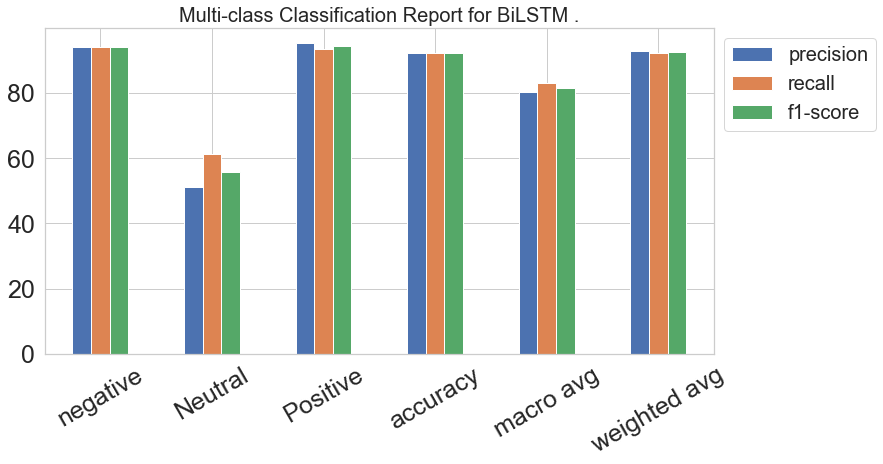

In [58]:
BiLSTMreport=report_generate(y_pred,"BiLSTM")
BiLSTMreport[1]

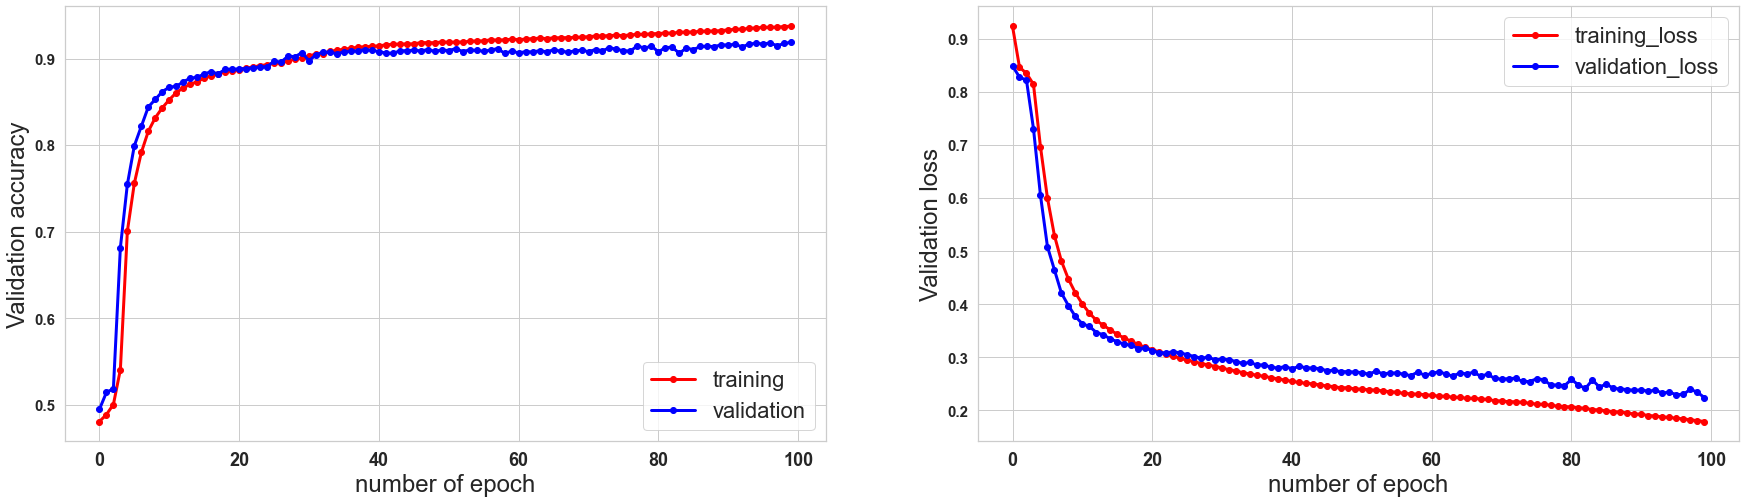

In [59]:
model_evaluate(BiLSTM_history)

In [60]:
def directional_classifier_model(model_name,file_name,GRU_unit, epochs, batch, p_optimizer= opt , 
                                   p_loss:str = 'sparse_categorical_crossentropy', p_metrics:list = ['accuracy']):
    """
    Build a directional Models for classification
    """
    filepath = PATH+ '/models/'+file_name
    reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss',  
                                    factor=0.5, patience=2, 
                                    verbose=1, mode='auto', 
                                    min_delta=0.001, cooldown=1, min_lr=0.00001)
    
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, 
                                             save_weights_only=False, mode='auto')
    
    callback_list = [acc_callback, checkpoint]
    
    print('----------------------------- sequential_classifier_model -----------------------------')
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1]),
        tf.keras.layers.SpatialDropout1D(0.2),
        model_name(GRU_unit,return_sequences=True),
#         model_name(128, dropout = 0.2),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(num_category, activation='sigmoid')
])
    model.compile(optimizer=p_optimizer, loss = p_loss, metrics = p_metrics)
    model.summary()
    model_history = model.fit(train_padded, y_train, 
                    epochs=epochs,
                    batch_size = batch,
                    validation_data=(validation_padded, y_valid), 
                    verbose=1,
                    callbacks = callback_list)
    return model,model_history

In [61]:
LSTM_model, LSTM_history =directional_classifier_model(model_name = LSTM,
                                                            file_name = 'LSTM.h5',
                                                            GRU_unit = 256,
                                                            epochs = epochs,
                                                            batch = batch)


----------------------------- sequential_classifier_model -----------------------------
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 200)          8600000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 100, 200)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 256)          467968    
_________________________________________________________________
dense_8 (Dense)              (None, 100, 64)           16448     
_________________________________________________________________
dropout_6 (Dropout)          (None, 100, 64)           0         
_________________________________________________________________
dense_9 (Dense)              (None, 100, 32)           2080      
________________________________

1277/1277 [==============================] - 50s 39ms/step - loss: 0.2496 - accuracy: 0.9207 - val_loss: 0.2832 - val_accuracy: 0.9089

Epoch 00063: val_accuracy did not improve from 0.90933
Epoch 64/100
1277/1277 [==============================] - 49s 39ms/step - loss: 0.2484 - accuracy: 0.9211 - val_loss: 0.2861 - val_accuracy: 0.9091

Epoch 00064: val_accuracy did not improve from 0.90933
Epoch 65/100
1277/1277 [==============================] - 51s 40ms/step - loss: 0.2479 - accuracy: 0.9210 - val_loss: 0.2802 - val_accuracy: 0.9095

Epoch 00065: val_accuracy improved from 0.90933 to 0.90945, saving model to /Ml files/drug review SA/models\LSTM.h5
Epoch 66/100
1277/1277 [==============================] - 51s 40ms/step - loss: 0.2471 - accuracy: 0.9222 - val_loss: 0.2816 - val_accuracy: 0.9098

Epoch 00066: val_accuracy improved from 0.90945 to 0.90980, saving model to /Ml files/drug review SA/models\LSTM.h5
Epoch 67/100
1277/1277 [==============================] - 50s 39ms/step - l

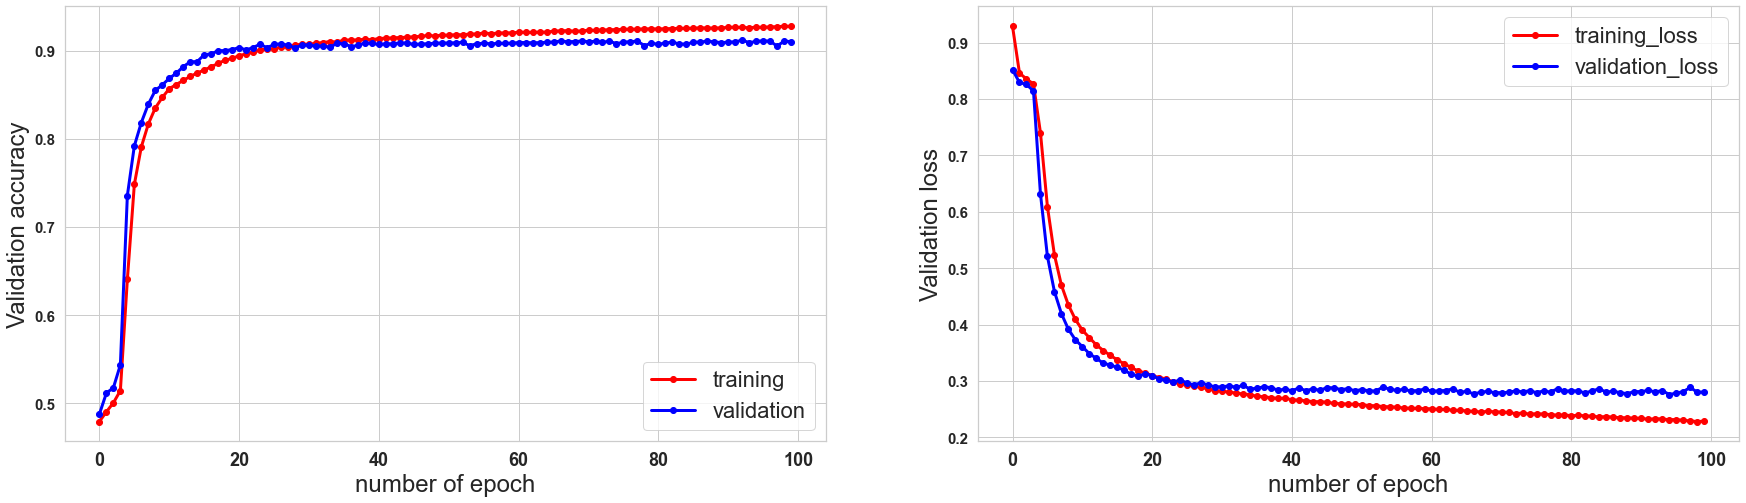

In [62]:
model_evaluate(LSTM_history)

In [63]:
#make predictions
model = load_model(model_path+"/LSTM.h5")
predictions = model.predict(test_padded)
y_pred = np.argmax(predictions, axis=1)
evaluation = model.evaluate(test_padded,y_test)
print('loss {}'.format(evaluation[0]))
print('Accuracy {}'.format(evaluation[1]))
print('Precision {}'.format(precision_score(y_test, y_pred , average="micro")))
print('Recall {}'.format(recall_score(y_test, y_pred , average="macro")))
print('f1 score {}'.format(f1_score(y_test, y_pred , average="micro")))



1345/1345 [==============================] - 18s 12ms/step - loss: 0.2743 - accuracy: 0.9120
loss 0.27426475286483765
Accuracy 0.912026584148407
Precision 0.9120265966103271
Recall 0.8018766612874813
f1 score 0.9120265966103271


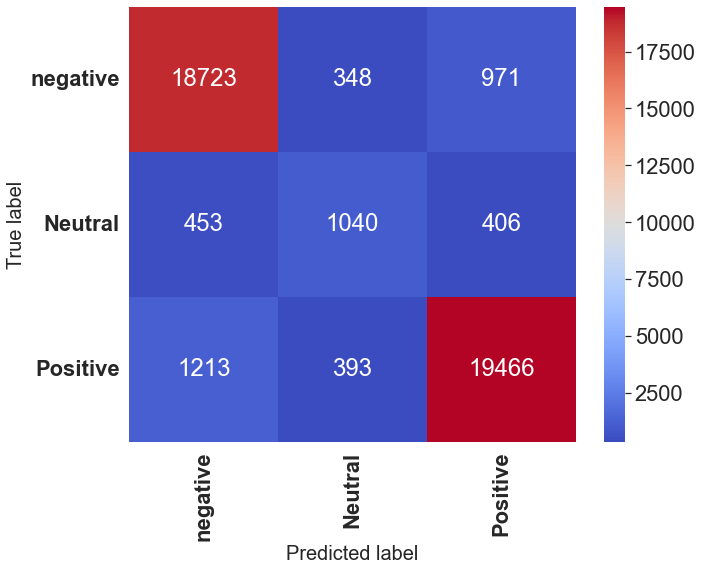

In [64]:
conf_matrix(y_pred)

,precision,recall,f1-score
negative,91.83,93.42,92.62
Neutral,58.39,54.77,56.52
Positive,93.39,92.38,92.88
accuracy,91.20,91.20,91.20
macro avg,81.21,80.19,80.67
weighted avg,91.12,91.20,91.15


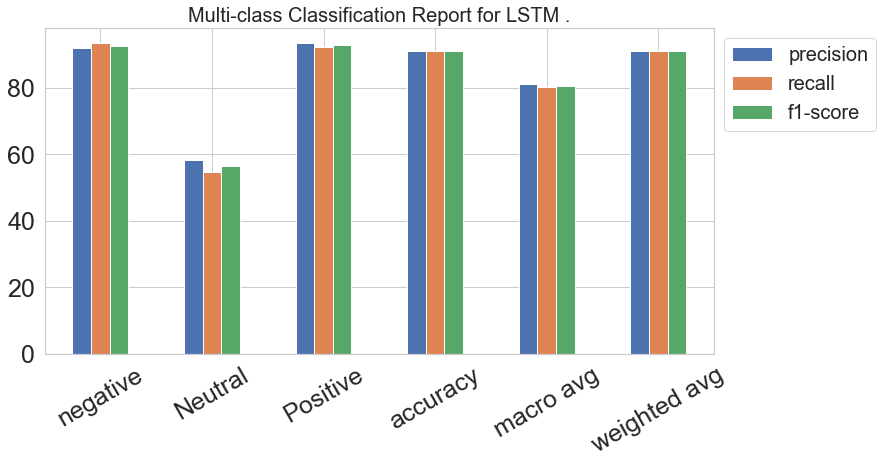

In [65]:
LSTMreport=report_generate(y_pred,"LSTM")
LSTMreport[1]

In [67]:
GRU_model, GRU_history =directional_classifier_model(model_name = GRU,
                                                            file_name = 'GRU.h5',
                                                            GRU_unit = 256,
                                                            epochs = epochs,
                                                            batch = batch)


----------------------------- sequential_classifier_model -----------------------------
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 200)          8600000   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 100, 200)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 100, 256)          351744    
_________________________________________________________________
dense_16 (Dense)             (None, 100, 64)           16448     
_________________________________________________________________
dropout_12 (Dropout)         (None, 100, 64)           0         
_________________________________________________________________
dense_17 (Dense)             (None, 100, 32)           2080      
________________________________


Epoch 00025: val_accuracy improved from 0.89271 to 0.89632, saving model to /Ml files/drug review SA/models\GRU.h5
Epoch 26/100
1277/1277 [==============================] - 46s 36ms/step - loss: 0.2994 - accuracy: 0.8906 - val_loss: 0.2922 - val_accuracy: 0.8997

Epoch 00026: val_accuracy improved from 0.89632 to 0.89969, saving model to /Ml files/drug review SA/models\GRU.h5
Epoch 27/100
1277/1277 [==============================] - 45s 36ms/step - loss: 0.2946 - accuracy: 0.8919 - val_loss: 0.2902 - val_accuracy: 0.9032

Epoch 00027: val_accuracy improved from 0.89969 to 0.90317, saving model to /Ml files/drug review SA/models\GRU.h5
Epoch 28/100
1277/1277 [==============================] - 45s 35ms/step - loss: 0.2896 - accuracy: 0.8934 - val_loss: 0.2875 - val_accuracy: 0.9034

Epoch 00028: val_accuracy improved from 0.90317 to 0.90341, saving model to /Ml files/drug review SA/models\GRU.h5
Epoch 29/100
1277/1277 [==============================] - 46s 36ms/step - loss: 0.2855 - acc

1277/1277 [==============================] - 45s 35ms/step - loss: 0.1767 - accuracy: 0.9381 - val_loss: 0.2308 - val_accuracy: 0.9205

Epoch 00098: val_accuracy did not improve from 0.92107
Epoch 99/100
1277/1277 [==============================] - 47s 36ms/step - loss: 0.1749 - accuracy: 0.9386 - val_loss: 0.2254 - val_accuracy: 0.9222

Epoch 00099: val_accuracy improved from 0.92107 to 0.92224, saving model to /Ml files/drug review SA/models\GRU.h5
Epoch 100/100
1277/1277 [==============================] - 46s 36ms/step - loss: 0.1743 - accuracy: 0.9391 - val_loss: 0.2220 - val_accuracy: 0.9198

Epoch 00100: val_accuracy did not improve from 0.92224


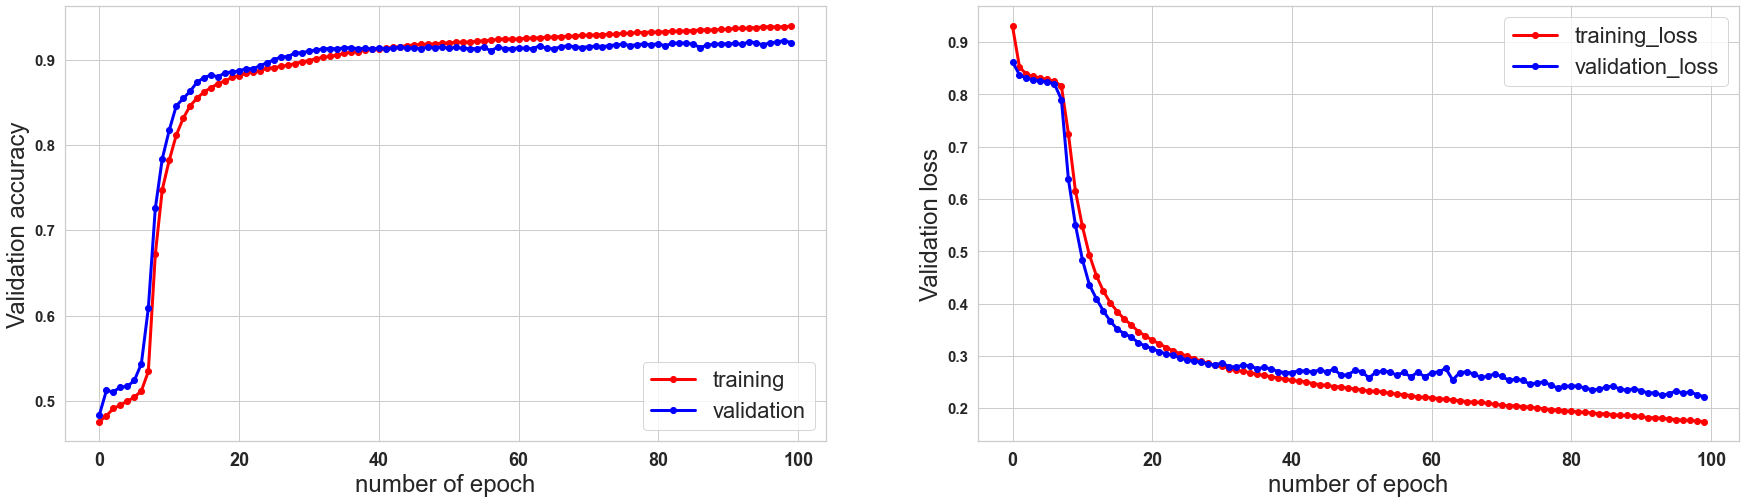

In [68]:
model_evaluate(GRU_history)

In [69]:
#make predictions
model = load_model(model_path+"/GRU.h5")
predictions = model.predict(test_padded)
y_pred = np.argmax(predictions, axis=1)
evaluation = model.evaluate(test_padded,y_test)
print('loss {}'.format(evaluation[0]))
print('Accuracy {}'.format(evaluation[1]))
print('Precision {}'.format(precision_score(y_test, y_pred , average="micro")))
print('Recall {}'.format(recall_score(y_test, y_pred , average="macro")))
print('f1 score {}'.format(f1_score(y_test, y_pred , average="micro")))



1345/1345 [==============================] - 17s 13ms/step - loss: 0.2206 - accuracy: 0.9222
loss 0.22057847678661346
Accuracy 0.9221630692481995
Precision 0.9221630669797503
Recall 0.8295561874922094
f1 score 0.9221630669797503


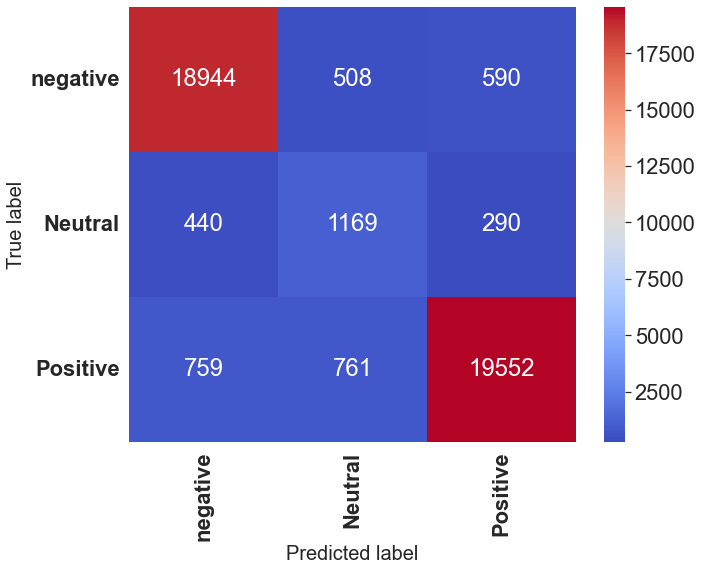

In [70]:
conf_matrix(y_pred)

,precision,recall,f1-score
negative,94.05,94.52,94.28
Neutral,47.95,61.56,53.91
Positive,95.69,92.79,94.22
accuracy,92.22,92.22,92.22
macro avg,79.23,82.96,80.80
weighted avg,92.82,92.22,92.47


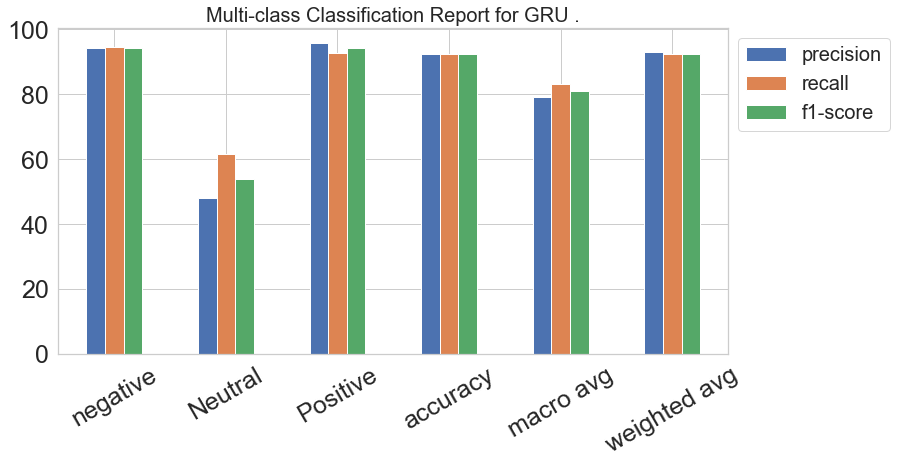

In [71]:
GRUreport=report_generate(y_pred,"GRU")
GRUreport[1]

In [72]:
# Plot all model results
def model_all_evaluate(history1,history2,history3,history4):
  sns.set_style("whitegrid")
  H1 = history1.history
  H2 = history2.history
  H3 = history3.history
  H4 = history4.history
  fig = plt.figure(figsize = (20, 8))
  plt.subplot(121)
  plt.xlabel("number of epoch")
  plt.ylabel("Validation accuracy")
  plt.plot(H1['val_accuracy'], label = 'BiGRU', marker='o', color='red', linewidth=3)
  plt.plot(H2['val_accuracy'], label = 'BiLSTM', marker='o', color='blue', linewidth=3)
  plt.plot(H3['val_accuracy'], label = 'LSTM', marker='o', color='yellow', linewidth=3)
  plt.plot(H4['val_accuracy'], label = 'GRU', marker='o', color='green', linewidth=3)
  plt.xticks( rotation=0, weight = 'bold')
  plt.yticks( rotation=0, weight = 'bold')
  plt.tick_params(rotation=0,axis='y', labelsize=15)
  plt.tick_params(rotation=0,axis='x', labelsize=18)
  plt.grid('white')
  plt.legend(prop={'size': 20})

  plt.subplot(122)
  plt.xlabel("number of epoch")
  plt.ylabel("Validation loss")
  plt.plot(H1['val_loss'], label = 'BiGRU', marker='o', color='red', linewidth=3)
  plt.plot(H2['val_loss'], label = 'BiLSTM', marker='o', color='blue', linewidth=3)
  plt.plot(H3['val_loss'], label = 'LSTM', marker='o', color='yellow', linewidth=3)
  plt.plot(H4['val_loss'], label = 'GRU', marker='o', color='green', linewidth=3)
  plt.xticks( rotation=0, weight = 'bold')
  plt.yticks( rotation=0, weight = 'bold')
  plt.tick_params(rotation=0,axis='y', labelsize=15)
  plt.tick_params(rotation=0,axis='x', labelsize=18)
  plt.grid('white')
  plt.legend(prop={'size': 20})


In [73]:
print(BiGRU_history.history['val_accuracy'])
print(BiGRU_history.history['val_loss'])

[0.9032895565032959, 0.8846913576126099, 0.9035220146179199, 0.9039869904518127, 0.8388934135437012, 0.9166569709777832, 0.9100313782691956, 0.9137510061264038, 0.9027083516120911, 0.8906195759773254, 0.9195629358291626, 0.9202603697776794, 0.9254910945892334, 0.9056143164634705, 0.9281646013259888, 0.9351388812065125, 0.9367662668228149, 0.9367662668228149, 0.9311867952346802, 0.9366499781608582, 0.9359526038169861, 0.9389747977256775, 0.936998724937439, 0.9431593418121338, 0.9387422800064087, 0.9408345818519592, 0.9397884607315063, 0.937231183052063, 0.9395559430122375, 0.9396722316741943, 0.9410670399665833, 0.9418807625770569, 0.9387422800064087, 0.9403696656227112, 0.9416482448577881, 0.9390910267829895, 0.9400209188461304, 0.9385098218917847, 0.9389747977256775, 0.9383935928344727, 0.9433918595314026, 0.9393234848976135, 0.9396722316741943, 0.9388585090637207, 0.9414157867431641, 0.9417644739151001, 0.9408345818519592, 0.9415320158004761, 0.9424619078636169, 0.9422294497489929, 0

In [74]:
print(BiLSTM_history.history['val_accuracy'])
print(BiLSTM_history.history['val_loss'])

[0.49505987763404846, 0.514587938785553, 0.5188887715339661, 0.6817389130592346, 0.7547367215156555, 0.7993723154067993, 0.8218063712120056, 0.8441241383552551, 0.8528420329093933, 0.8617923855781555, 0.8669068813323975, 0.8679530620574951, 0.8730675578117371, 0.8773683309555054, 0.878298282623291, 0.8821341395378113, 0.8849238753318787, 0.8821341395378113, 0.887713611125946, 0.8874810934066772, 0.8880622982978821, 0.8884110450744629, 0.8894571661949158, 0.8901546001434326, 0.8906195759773254, 0.8968964219093323, 0.8958503007888794, 0.9028245806694031, 0.9021271467208862, 0.9067767262458801, 0.8973613977432251, 0.9044519066810608, 0.9073578715324402, 0.9073578715324402, 0.9054980874061584, 0.907706618309021, 0.9082878232002258, 0.9089852571487427, 0.9102638363838196, 0.9094501733779907, 0.908055305480957, 0.9063117504119873, 0.9060792922973633, 0.9087527394294739, 0.9091014862060547, 0.9095664024353027, 0.9088690280914307, 0.9102638363838196, 0.9084040522575378, 0.9097989201545715, 0.9

In [75]:
print(LSTM_history.history['val_accuracy'])
print(LSTM_history.history['val_loss'])

[0.487969309091568, 0.5117982029914856, 0.5178425908088684, 0.5437638163566589, 0.7357898354530334, 0.7920492887496948, 0.8185516595840454, 0.839358389377594, 0.8549343347549438, 0.8612111806869507, 0.8685342073440552, 0.8744624257087708, 0.8817854523658752, 0.8873648643493652, 0.8875973224639893, 0.8953853249549866, 0.8963152170181274, 0.9000348448753357, 0.9000348448753357, 0.9013134837150574, 0.9034057855606079, 0.9008485674858093, 0.9035220146179199, 0.9073578715324402, 0.9032895565032959, 0.9071254134178162, 0.907590389251709, 0.9063117504119873, 0.9031733274459839, 0.9064279794692993, 0.9065442085266113, 0.9050331115722656, 0.9054980874061584, 0.9039869904518127, 0.9082878232002258, 0.907939076423645, 0.9046844244003296, 0.9059630632400513, 0.9087527394294739, 0.9082878232002258, 0.9071254134178162, 0.907822847366333, 0.907706618309021, 0.9088690280914307, 0.9087527394294739, 0.9070091843605042, 0.907474160194397, 0.907822847366333, 0.9084040522575378, 0.9086365103721619, 0.90863

In [76]:
print(GRU_history.history['val_accuracy'])
print(GRU_history.history['val_loss'])

[0.4836684763431549, 0.5121469497680664, 0.5104033350944519, 0.5163314938545227, 0.5167964696884155, 0.524003267288208, 0.5432988405227661, 0.6085086464881897, 0.7255608439445496, 0.7837963700294495, 0.8173893094062805, 0.8457514643669128, 0.854353129863739, 0.8629547953605652, 0.8737649917602539, 0.8787631988525391, 0.8819016814231873, 0.8796931505203247, 0.8848076462745667, 0.8851563334465027, 0.8867836594581604, 0.8893409371376038, 0.8893409371376038, 0.8927118182182312, 0.8963152170181274, 0.8996861577033997, 0.9031733274459839, 0.9034057855606079, 0.907822847366333, 0.907939076423645, 0.9100313782691956, 0.9111937880516052, 0.9125886559486389, 0.912937343120575, 0.9125886559486389, 0.9136347770690918, 0.9140997529029846, 0.9125886559486389, 0.913169801235199, 0.9123561382293701, 0.9136347770690918, 0.912937343120575, 0.913053572177887, 0.9143322110176086, 0.9136347770690918, 0.9137510061264038, 0.9125886559486389, 0.9147971868515015, 0.9135185480117798, 0.9151458740234375, 0.91316

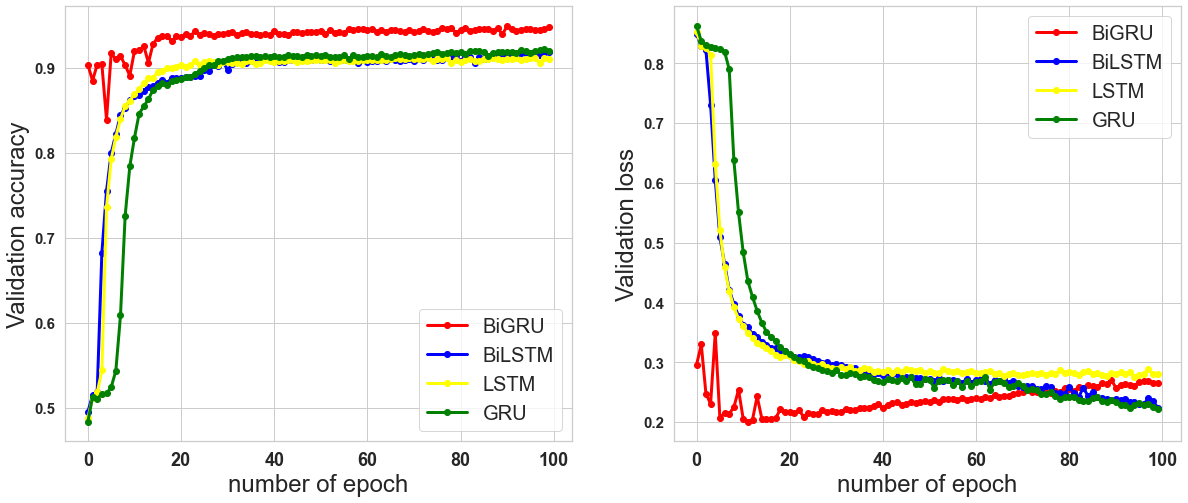

In [77]:
model_all_evaluate(BiGRU_history, BiLSTM_history,LSTM_history, GRU_history )

In [78]:
Bigru = load_model(model_path+"/BiGRU.h5")
Bilstm = load_model(model_path+"/BiLSTM.h5")
lstm = load_model(model_path+"/LSTM.h5")
gru = load_model(model_path+"/GRU.h5")
MLA = {
     'Bidirectional GRU' : Bigru,
     'Bidirectional LSTM' : Bilstm,
     'LSTM' : lstm,
     'GRU' : gru, 
}

columns = []
compare = pd.DataFrame(columns = columns)
# n_classes=4
row_index = 0
for name,alg in MLA.items():
    MLA_name = name
    evaluation = alg.evaluate(test_padded,y_test)
    y_pred = alg.predict(test_padded)
    y_pred = np.argmax(y_pred, axis=1)
    macro_recall = recall_score(y_test, y_pred , average="macro")
    micro_precision = precision_score(y_test, y_pred , average="micro")
    f1_score =  2 * (micro_precision * macro_recall) / (micro_precision + macro_recall)
    compare.loc[row_index,'Name'] = MLA_name
    compare.loc[row_index, 'Accuracy'] = evaluation[1]
    compare.loc[row_index, 'loss'] = evaluation[0]
    compare.loc[row_index, 'Precision'] = micro_precision
    compare.loc[row_index, 'Recall'] = macro_recall
    compare.loc[row_index, 'F1 Score'] = f1_score
    row_index+=1
    
compare.sort_values(by = ['Accuracy'], ascending = False, inplace = True)    
compare

1345/1345 [==============================] - 19s 13ms/step - loss: 0.2206 - accuracy: 0.9222


,Name,Accuracy,loss,Precision,Recall,F1 Score
0,Bidirectional GRU,0.950922,0.265777,0.950922,0.940959,0.945914
1,Bidirectional LSTM,0.923000,0.219580,0.923000,0.829410,0.873706
3,GRU,0.922163,0.220578,0.922163,0.829556,0.873412
2,LSTM,0.912027,0.274265,0.912027,0.801877,0.853412


**DIrectional Hybrid Model**

**CNN-LSTM**

In [17]:
def directional_hybrid_classifier_model(model_name,file_name,GRU_unit, epochs, batch, p_optimizer = opt , 
                                   p_loss:str = 'sparse_categorical_crossentropy', p_metrics:list = ['accuracy']):
    """
    Build a directional Models for classification
    """
    filepath = PATH + '/models/'+file_name
    reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss',  
                                    factor=0.5, patience=2, 
                                    verbose=1, mode='auto', 
                                    min_delta=0.001, cooldown=1, min_lr=0.00001)
    
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, 
                                             save_weights_only=False, mode='auto')
    
    callback_list = [acc_callback, checkpoint]
    
    print('----------------------------- Hybrid_sequential_classifier_model -----------------------------')
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1]),
        tf.keras.layers.SpatialDropout1D(0.7),
        tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        model_name(GRU_unit,return_sequences=True),
        # tf.keras.layers.Dense(128, activation='relu'),
        # tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(num_category, activation='sigmoid')
])
    model.compile(optimizer=p_optimizer, loss = p_loss, metrics = p_metrics)
    model.summary()
    model_history = model.fit(train_padded, y_train, 
                    epochs=epochs,
                    batch_size = batch,
                    validation_data=(validation_padded, y_valid), 
                    verbose=1,
                    callbacks = callback_list)
    return model,model_history

In [18]:
CLSTM_model, CLSTM_history =directional_hybrid_classifier_model(model_name = LSTM,
                                                            file_name = 'CLSTM.h5',
                                                            GRU_unit =200,
                                                            epochs = epochs,
                                                            batch = batch)


----------------------------- Hybrid_sequential_classifier_model -----------------------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 200)          8600000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 100, 200)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 100, 32)           19232     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 50, 32)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 50, 200)           186400    
_________________________________________________________________
dense (Dense)                (None, 50, 64)            12864     
___________________________


Epoch 00027: val_accuracy did not improve from 0.94955
Epoch 28/100
1277/1277 [==============================] - 11s 9ms/step - loss: 0.1170 - accuracy: 0.9609 - val_loss: 0.1700 - val_accuracy: 0.9471

Epoch 00028: val_accuracy did not improve from 0.94955
Epoch 29/100
1277/1277 [==============================] - 11s 9ms/step - loss: 0.1134 - accuracy: 0.9623 - val_loss: 0.1511 - val_accuracy: 0.9499

Epoch 00029: val_accuracy improved from 0.94955 to 0.94990, saving model to /Ml files/drug review SA/models\CLSTM.h5
Epoch 30/100
1277/1277 [==============================] - 11s 9ms/step - loss: 0.1146 - accuracy: 0.9618 - val_loss: 0.1491 - val_accuracy: 0.9472

Epoch 00030: val_accuracy did not improve from 0.94990
Epoch 31/100
1277/1277 [==============================] - 11s 9ms/step - loss: 0.1262 - accuracy: 0.9626 - val_loss: 0.1774 - val_accuracy: 0.9506

Epoch 00031: val_accuracy improved from 0.94990 to 0.95060, saving model to /Ml files/drug review SA/models\CLSTM.h5
Epoch 32

1277/1277 [==============================] - 40s 31ms/step - loss: 0.1079 - accuracy: 0.9659 - val_loss: 0.1712 - val_accuracy: 0.9502

Epoch 00066: val_accuracy did not improve from 0.95432
Epoch 67/100
1277/1277 [==============================] - 41s 32ms/step - loss: 0.1087 - accuracy: 0.9666 - val_loss: 0.1734 - val_accuracy: 0.9502

Epoch 00067: val_accuracy did not improve from 0.95432
Epoch 68/100
1277/1277 [==============================] - 40s 31ms/step - loss: 0.2067 - accuracy: 0.9660 - val_loss: 0.1558 - val_accuracy: 0.9489

Epoch 00068: val_accuracy did not improve from 0.95432
Epoch 69/100
1277/1277 [==============================] - 41s 32ms/step - loss: 0.1096 - accuracy: 0.9661 - val_loss: 0.2032 - val_accuracy: 0.9509

Epoch 00069: val_accuracy did not improve from 0.95432
Epoch 70/100
1277/1277 [==============================] - 40s 31ms/step - loss: 0.1237 - accuracy: 0.9661 - val_loss: 0.1530 - val_accuracy: 0.9523

Epoch 00070: val_accuracy did not improve from 0

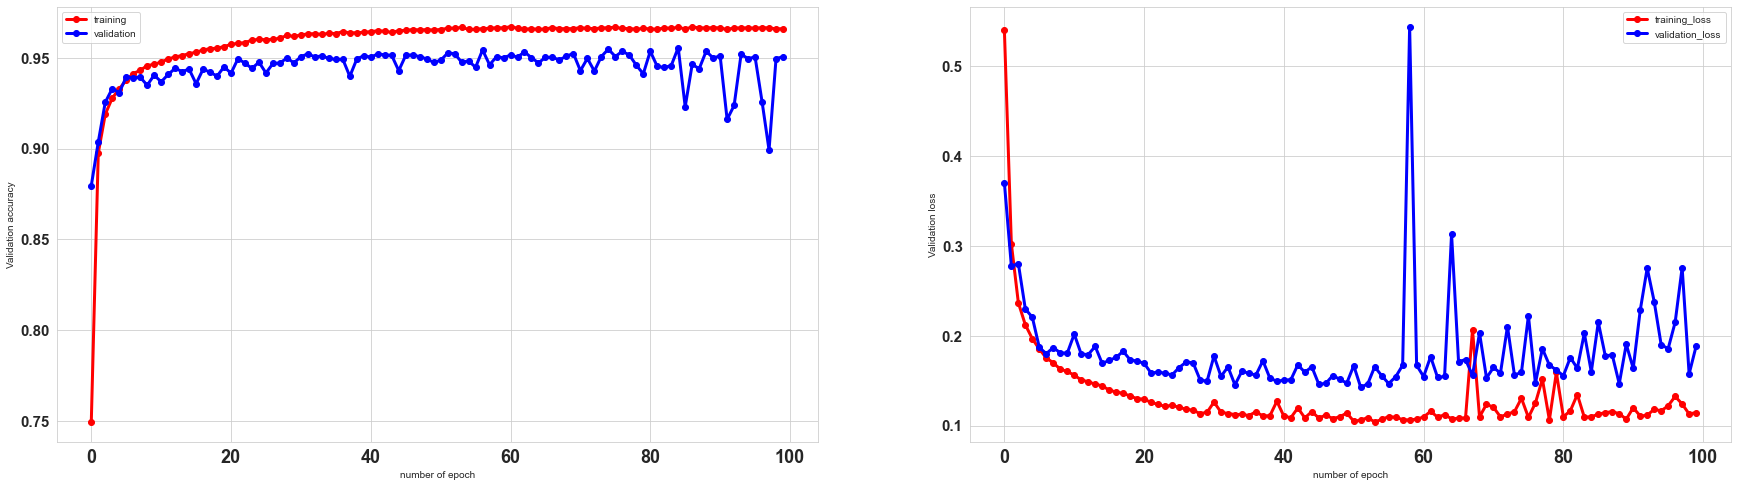

In [22]:
model_evaluate(CLSTM_history)

In [24]:
CLSTM_history.history

{'loss': [0.5405855774879456,
  0.30226051807403564,
  0.23672455549240112,
  0.21213293075561523,
  0.19670599699020386,
  0.1851624995470047,
  0.17525406181812286,
  0.1697934865951538,
  0.16277676820755005,
  0.16021299362182617,
  0.1560874730348587,
  0.15076301991939545,
  0.14877186715602875,
  0.14600829780101776,
  0.14425472915172577,
  0.13943350315093994,
  0.137308269739151,
  0.13586772978305817,
  0.1329263150691986,
  0.12980112433433533,
  0.12941014766693115,
  0.12567204236984253,
  0.1235978975892067,
  0.12124787271022797,
  0.12263321876525879,
  0.12021534889936447,
  0.11824000626802444,
  0.11699360609054565,
  0.11338795721530914,
  0.11464042216539383,
  0.12616044282913208,
  0.11486878991127014,
  0.11339015513658524,
  0.1122656911611557,
  0.1123955249786377,
  0.11115214228630066,
  0.11529257893562317,
  0.11068600416183472,
  0.11091022193431854,
  0.12702614068984985,
  0.11042841523885727,
  0.10875223577022552,
  0.11958948522806168,
  0.108556188

1345/1345 [==============================] - 16s 11ms/step - loss: 0.1467 - accuracy: 0.9543
loss 0.1466953456401825
Accuracy 0.954292893409729
Precision 0.9542928881965917
Recall 0.8465707910283745
f1 score 0.9542928881965917


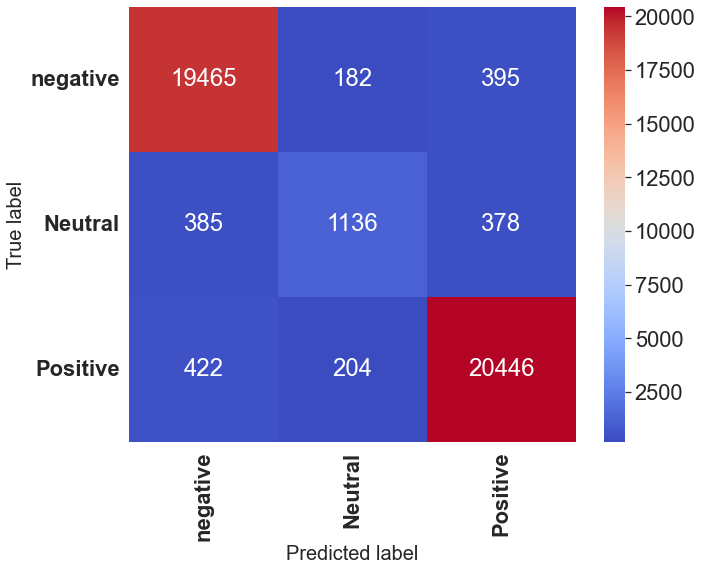

In [25]:
#make predictions
model = load_model(model_path+"/CLSTM.h5")
predictions = model.predict(test_padded)
y_pred = np.argmax(predictions, axis=1)
evaluation = model.evaluate(test_padded,y_test)
print('loss {}'.format(evaluation[0]))
print('Accuracy {}'.format(evaluation[1]))
print('Precision {}'.format(precision_score(y_test, y_pred , average="micro")))
print('Recall {}'.format(recall_score(y_test, y_pred , average="macro")))
print('f1 score {}'.format(f1_score(y_test, y_pred , average="micro")))

conf_matrix(y_pred)

**CNN-GRU**

In [26]:
CGRU_model, CGRU_history =directional_hybrid_classifier_model(model_name = GRU,
                                                            file_name = 'CGRU.h5',
                                                            GRU_unit =200,
                                                            epochs = epochs,
                                                            batch = batch)


----------------------------- Hybrid_sequential_classifier_model -----------------------------
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 200)          8600000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 100, 200)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 32)           19232     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 32)            0         
_________________________________________________________________
gru (GRU)                    (None, 50, 200)           140400    
_________________________________________________________________
dense_4 (Dense)              (None, 50, 64)            12864     
_________________________

Epoch 29/100
1277/1277 [==============================] - 39s 31ms/step - loss: 0.1202 - accuracy: 0.9601 - val_loss: 0.1845 - val_accuracy: 0.9348

Epoch 00029: val_accuracy did not improve from 0.94804
Epoch 30/100
1277/1277 [==============================] - 39s 31ms/step - loss: 0.1202 - accuracy: 0.9600 - val_loss: 0.1987 - val_accuracy: 0.9243

Epoch 00030: val_accuracy did not improve from 0.94804
Epoch 31/100
1277/1277 [==============================] - 39s 31ms/step - loss: 0.1172 - accuracy: 0.9617 - val_loss: 0.1873 - val_accuracy: 0.9321

Epoch 00031: val_accuracy did not improve from 0.94804
Epoch 32/100
1277/1277 [==============================] - 39s 30ms/step - loss: 0.1162 - accuracy: 0.9618 - val_loss: 0.1872 - val_accuracy: 0.9291

Epoch 00032: val_accuracy did not improve from 0.94804
Epoch 33/100
1277/1277 [==============================] - 39s 30ms/step - loss: 0.1166 - accuracy: 0.9624 - val_loss: 0.1768 - val_accuracy: 0.9379

Epoch 00033: val_accuracy did not i

1277/1277 [==============================] - 39s 31ms/step - loss: 0.1097 - accuracy: 0.9671 - val_loss: 0.2026 - val_accuracy: 0.9221

Epoch 00069: val_accuracy did not improve from 0.94804
Epoch 70/100
1277/1277 [==============================] - 39s 31ms/step - loss: 0.1105 - accuracy: 0.9664 - val_loss: 0.2792 - val_accuracy: 0.8845

Epoch 00070: val_accuracy did not improve from 0.94804
Epoch 71/100
1277/1277 [==============================] - 39s 30ms/step - loss: 0.1109 - accuracy: 0.9674 - val_loss: 0.2708 - val_accuracy: 0.8793

Epoch 00071: val_accuracy did not improve from 0.94804
Epoch 72/100
1277/1277 [==============================] - 39s 31ms/step - loss: 0.1146 - accuracy: 0.9662 - val_loss: 0.2431 - val_accuracy: 0.8985

Epoch 00072: val_accuracy did not improve from 0.94804
Epoch 73/100
1277/1277 [==============================] - 39s 31ms/step - loss: 0.1106 - accuracy: 0.9664 - val_loss: 0.2201 - val_accuracy: 0.9106

Epoch 00073: val_accuracy did not improve from 0

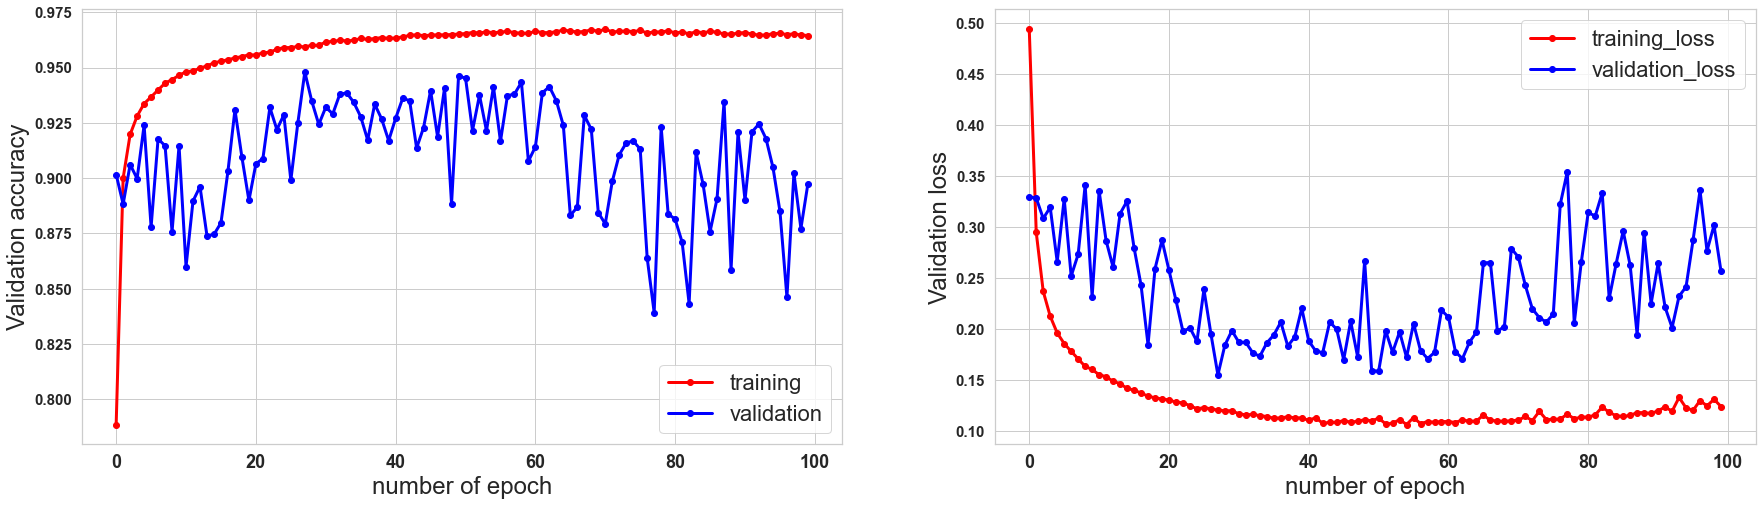

In [27]:
model_evaluate(CGRU_history)

In [28]:
CGRU_history

1345/1345 [==============================] - 18s 12ms/step - loss: 0.1464 - accuracy: 0.9487
loss 0.14636141061782837
Accuracy 0.9487364292144775
Precision 0.8541170462121762
Recall 0.8666425018453525
f1 score 0.8600217017018682


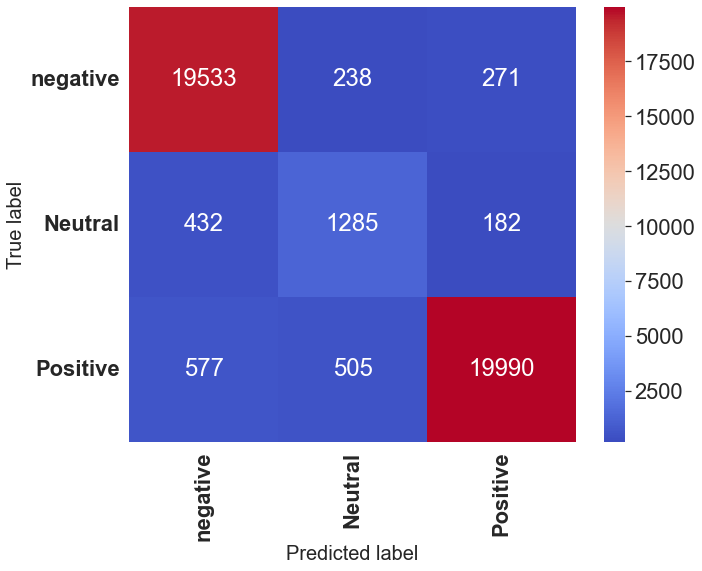

In [29]:
#make predictions

model = load_model(model_path+"/CGRU.h5")
predictions = model.predict(test_padded)
y_pred = np.argmax(predictions, axis=1)
evaluation = model.evaluate(test_padded,y_test)
print('loss {}'.format(evaluation[0]))
print('Accuracy {}'.format(evaluation[1]))
print('Precision {}'.format(precision_score(y_test, y_pred , average="macro")))
print('Recall {}'.format(recall_score(y_test, y_pred , average="macro")))
print('f1 score {}'.format(f1_score(y_test, y_pred , average="macro")))

conf_matrix(y_pred)

**Bi-directional Hybrid Model**

In [30]:
def bidirectional_hybrid_classifier_model(model_name,file_name,GRU_unit, epochs, batch, p_optimizer = opt , 
                                   p_loss:str = 'sparse_categorical_crossentropy', p_metrics:list = ['accuracy']):
    """
    Build a directional Models for classification
    """
    filepath =PATH + '/models/'+file_name
    reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss',  
                                    factor=0.5, patience=2, 
                                    verbose=1, mode='auto', 
                                    min_delta=0.001, cooldown=1, min_lr=0.00001)
    
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, 
                                             save_weights_only=False, mode='auto')
    
    callback_list = [acc_callback, checkpoint]
    
    print('----------------------------- Biderectional Hybrid_sequential_classifier_model -----------------------------')
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(73971, embedding_dim, input_length=train_padded.shape[1]),
        tf.keras.layers.SpatialDropout1D(0.7),
        tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'),
        
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Bidirectional(model_name(GRU_unit,return_sequences=True)),
        # tf.keras.layers.Dense(128, activation='relu'),
        # tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(num_category, activation='sigmoid')
])
    model.compile(optimizer=p_optimizer, loss = p_loss, metrics = p_metrics)
    model.summary()
    model_history = model.fit(train_padded, y_train, 
                    epochs=epochs,
                    batch_size = batch,
                    validation_data=(validation_padded, y_valid), 
                    verbose=1,
                    callbacks = callback_list)
    return model,model_history

**CNN-BiLSTM**

----------------------------- Biderectional Hybrid_sequential_classifier_model -----------------------------
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 200)          14794200  
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 100, 200)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 100, 32)           19232     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 50, 32)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 400)           372800    
_________________________________________________________________
dense_8 (Dense)              (None, 50, 64)            25664     
___________

Epoch 27/100
1277/1277 [==============================] - 62s 48ms/step - loss: 0.1201 - accuracy: 0.9609 - val_loss: 0.1651 - val_accuracy: 0.9509

Epoch 00027: val_accuracy did not improve from 0.95316
Epoch 28/100
1277/1277 [==============================] - 60s 47ms/step - loss: 0.1245 - accuracy: 0.9610 - val_loss: 0.1604 - val_accuracy: 0.9484

Epoch 00028: val_accuracy did not improve from 0.95316
Epoch 29/100
1277/1277 [==============================] - 60s 47ms/step - loss: 0.1207 - accuracy: 0.9619 - val_loss: 0.1503 - val_accuracy: 0.9507

Epoch 00029: val_accuracy did not improve from 0.95316
Epoch 30/100
1277/1277 [==============================] - 60s 47ms/step - loss: 0.1195 - accuracy: 0.9621 - val_loss: 0.1746 - val_accuracy: 0.9515

Epoch 00030: val_accuracy did not improve from 0.95316
Epoch 31/100
1277/1277 [==============================] - 62s 48ms/step - loss: 0.1226 - accuracy: 0.9620 - val_loss: 0.1931 - val_accuracy: 0.9458

Epoch 00031: val_accuracy did not i

1277/1277 [==============================] - 58s 46ms/step - loss: 0.1372 - accuracy: 0.9648 - val_loss: 0.1461 - val_accuracy: 0.9514

Epoch 00066: val_accuracy did not improve from 0.95513
Epoch 67/100
1277/1277 [==============================] - 59s 46ms/step - loss: 0.1288 - accuracy: 0.9638 - val_loss: 0.1517 - val_accuracy: 0.9556

Epoch 00067: val_accuracy improved from 0.95513 to 0.95560, saving model to /Ml files/drug review SA/models\CBILSTM.h5
Epoch 68/100
1277/1277 [==============================] - 58s 46ms/step - loss: 0.1550 - accuracy: 0.9633 - val_loss: 0.1672 - val_accuracy: 0.9557

Epoch 00068: val_accuracy improved from 0.95560 to 0.95571, saving model to /Ml files/drug review SA/models\CBILSTM.h5
Epoch 69/100
1277/1277 [==============================] - 44s 35ms/step - loss: 0.1387 - accuracy: 0.9644 - val_loss: 0.1724 - val_accuracy: 0.9570

Epoch 00069: val_accuracy improved from 0.95571 to 0.95699, saving model to /Ml files/drug review SA/models\CBILSTM.h5
Epoch

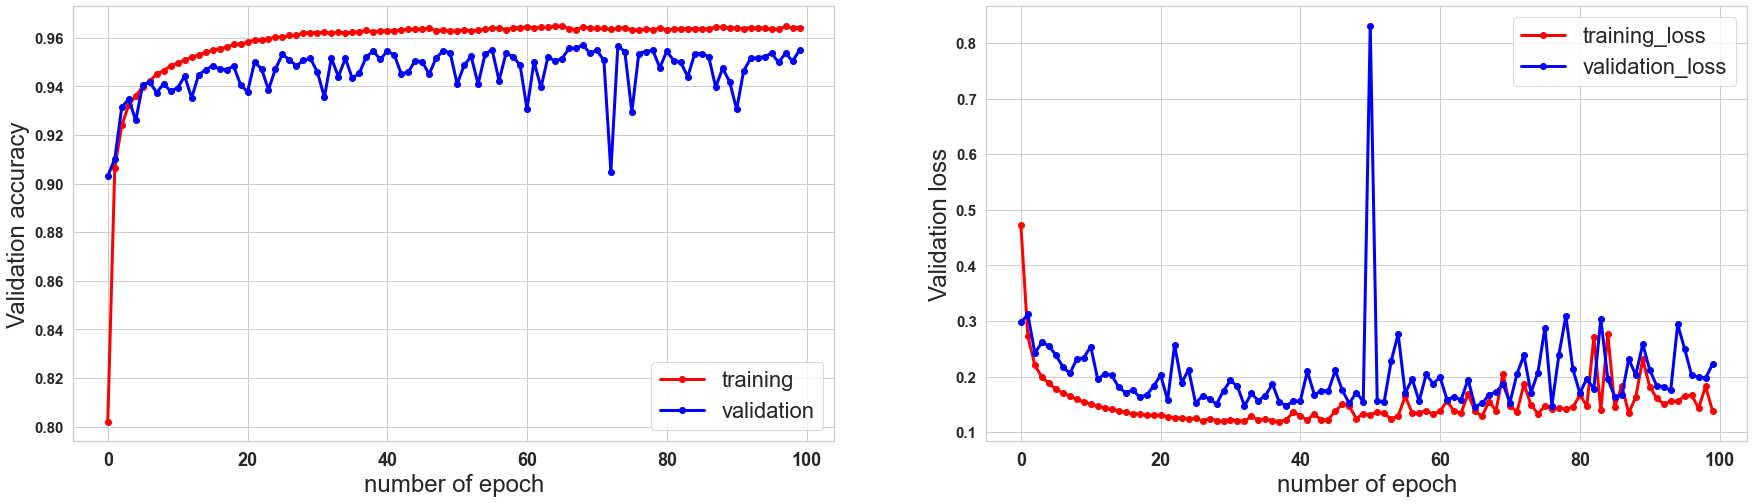

In [31]:
CBILSTM_model, CBILSTM_history =bidirectional_hybrid_classifier_model(model_name = LSTM,
                                                            file_name = 'CBILSTM.h5',
                                                            GRU_unit =200,
                                                            epochs = epochs,
                                                            batch = batch)
model_evaluate(CBILSTM_history)

1345/1345 [==============================] - 6s 4ms/step - loss: 0.2145 - accuracy: 0.9551
loss 0.21448782086372375
Accuracy 0.9551066160202026
Precision 0.8841556643540057
Recall 0.8535791581829358
f1 score 0.867505817501914


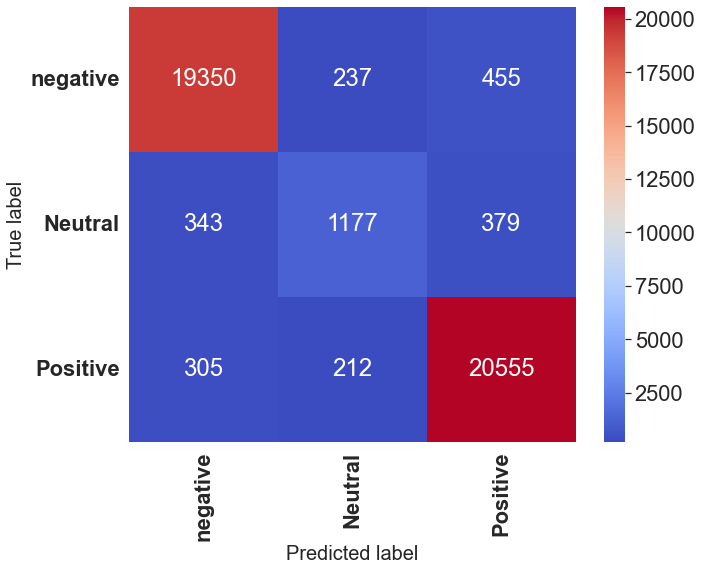

In [32]:
#make predictions


model = load_model(model_path+"/CBILSTM.h5")
predictions = model.predict(test_padded)
y_pred = np.argmax(predictions, axis=1)
evaluation = model.evaluate(test_padded,y_test)
print('loss {}'.format(evaluation[0]))
print('Accuracy {}'.format(evaluation[1]))
print('Precision {}'.format(precision_score(y_test, y_pred , average="macro")))
print('Recall {}'.format(recall_score(y_test, y_pred , average="macro")))
print('f1 score {}'.format(f1_score(y_test, y_pred , average="macro")))

conf_matrix(y_pred)

**CNN-BiGRU**

In [33]:
CBIGRU_model, CBIGRU_history =bidirectional_hybrid_classifier_model(model_name = GRU,
                                                            file_name = 'CBIGRU.h5',
                                                            GRU_unit =200,
                                                            epochs = epochs,
                                                            batch = batch)


----------------------------- Biderectional Hybrid_sequential_classifier_model -----------------------------
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 200)          14794200  
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 100, 200)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 100, 32)           19232     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 50, 32)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 400)           280800    
_________________________________________________________________
dense_12 (Dense)             (None, 50, 64)            25664     
___________

1277/1277 [==============================] - 16s 13ms/step - loss: 0.1539 - accuracy: 0.9534 - val_loss: 0.3300 - val_accuracy: 0.9179

Epoch 00027: val_accuracy did not improve from 0.94676
Epoch 28/100
1277/1277 [==============================] - 17s 13ms/step - loss: 0.1518 - accuracy: 0.9539 - val_loss: 0.1973 - val_accuracy: 0.9426

Epoch 00028: val_accuracy did not improve from 0.94676
Epoch 29/100
1277/1277 [==============================] - 16s 13ms/step - loss: 0.1504 - accuracy: 0.9536 - val_loss: 0.2549 - val_accuracy: 0.9390

Epoch 00029: val_accuracy did not improve from 0.94676
Epoch 30/100
1277/1277 [==============================] - 16s 13ms/step - loss: 0.1542 - accuracy: 0.9538 - val_loss: 0.2890 - val_accuracy: 0.9174

Epoch 00030: val_accuracy did not improve from 0.94676
Epoch 31/100
1277/1277 [==============================] - 16s 13ms/step - loss: 0.1501 - accuracy: 0.9539 - val_loss: 0.3823 - val_accuracy: 0.9471

Epoch 00031: val_accuracy improved from 0.94676 


Epoch 00066: val_accuracy did not improve from 0.94932
Epoch 67/100
1277/1277 [==============================] - 24s 19ms/step - loss: 0.1731 - accuracy: 0.9562 - val_loss: 0.7001 - val_accuracy: 0.9135

Epoch 00067: val_accuracy did not improve from 0.94932
Epoch 68/100
1277/1277 [==============================] - 42s 33ms/step - loss: 0.1754 - accuracy: 0.9557 - val_loss: 0.3193 - val_accuracy: 0.9439

Epoch 00068: val_accuracy did not improve from 0.94932
Epoch 69/100
1277/1277 [==============================] - 41s 32ms/step - loss: 0.1727 - accuracy: 0.9560 - val_loss: 1.2113 - val_accuracy: 0.9435

Epoch 00069: val_accuracy did not improve from 0.94932
Epoch 70/100
1277/1277 [==============================] - 26s 20ms/step - loss: 0.1691 - accuracy: 0.9556 - val_loss: 0.7563 - val_accuracy: 0.9235

Epoch 00070: val_accuracy did not improve from 0.94932
Epoch 71/100
1277/1277 [==============================] - 42s 33ms/step - loss: 0.1647 - accuracy: 0.9560 - val_loss: 0.5846 - v

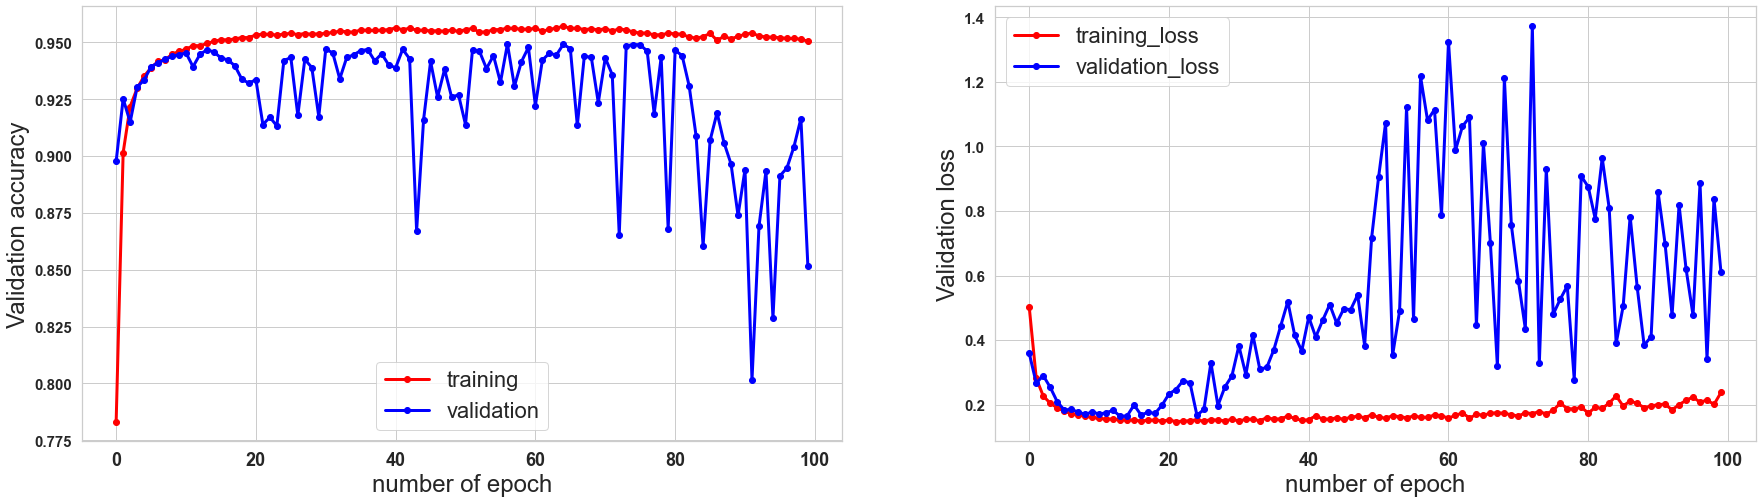

In [34]:
model_evaluate(CBIGRU_history)

1345/1345 [==============================] - 14s 9ms/step - loss: 0.3724 - accuracy: 0.9490
loss 0.37238290905952454
Accuracy 0.9489688873291016
Precision 0.9578450594280671
Recall 0.806618828415695
f1 score 0.8537570349170919


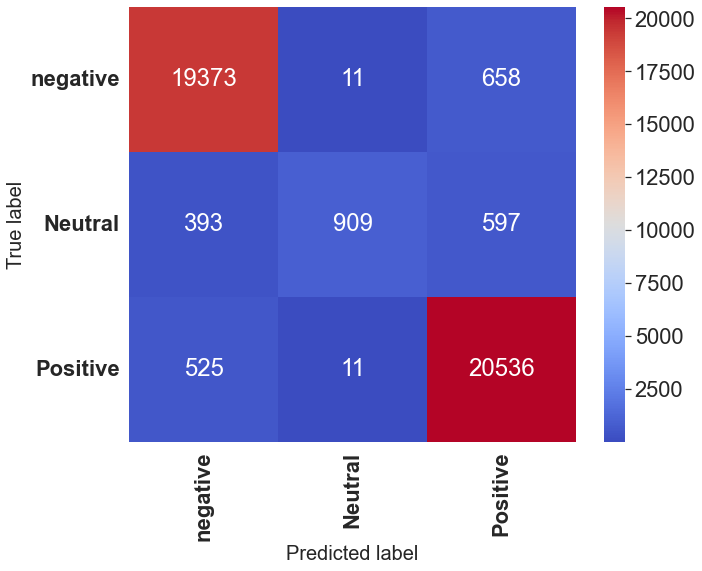

In [35]:
#make predictions


model = load_model(model_path+"/CBIGRU.h5")
predictions = model.predict(test_padded)
y_pred = np.argmax(predictions, axis=1)
evaluation = model.evaluate(test_padded,y_test)
print('loss {}'.format(evaluation[0]))
print('Accuracy {}'.format(evaluation[1]))
print('Precision {}'.format(precision_score(y_test, y_pred , average="macro")))
print('Recall {}'.format(recall_score(y_test, y_pred , average="macro")))
print('f1 score {}'.format(f1_score(y_test, y_pred , average="macro")))

conf_matrix(y_pred)

In [36]:
# Plot all model results
def model_all_evaluate(history1,history2,history3,history4):
  sns.set_style("whitegrid")
  H1 = history1.history
  H2 = history2.history
  H3 = history3.history
  H4 = history4.history
  fig = plt.figure(figsize = (20, 8))
  plt.subplot(121)
  plt.xlabel("number of epoch")
  plt.ylabel("Validation accuracy")
  plt.plot(H1['val_accuracy'], label = 'CNN-BiGRU', marker='o', color='red', linewidth=3)
  plt.plot(H2['val_accuracy'], label = 'CNN-BiLSTM', marker='o', color='blue', linewidth=3)
  plt.plot(H3['val_accuracy'], label = 'CNN-LSTM', marker='o', color='yellow', linewidth=3)
  plt.plot(H4['val_accuracy'], label = 'CNN-GRU', marker='o', color='green', linewidth=3)
  plt.xticks( rotation=0, weight = 'bold')
  plt.yticks( rotation=0, weight = 'bold')
  plt.tick_params(rotation=0,axis='y', labelsize=15)
  plt.tick_params(rotation=0,axis='x', labelsize=18)
  plt.grid('white')
  plt.legend(prop={'size': 20})

  plt.subplot(122)
  plt.xlabel("number of epoch")
  plt.ylabel("Validation loss")
  plt.plot(H1['val_loss'], label = 'CNN-BiGRU', marker='o', color='red', linewidth=3)
  plt.plot(H2['val_loss'], label = 'CNN-BiLSTM', marker='o', color='blue', linewidth=3)
  plt.plot(H3['val_loss'], label = 'CNN-LSTM', marker='o', color='yellow', linewidth=3)
  plt.plot(H4['val_loss'], label = 'CNN-GRU', marker='o', color='green', linewidth=3)
  plt.xticks( rotation=0, weight = 'bold')
  plt.yticks( rotation=0, weight = 'bold')
  plt.tick_params(rotation=0,axis='y', labelsize=15)
  plt.tick_params(rotation=0,axis='x', labelsize=18)
  plt.grid('white')
  plt.legend(prop={'size': 20})


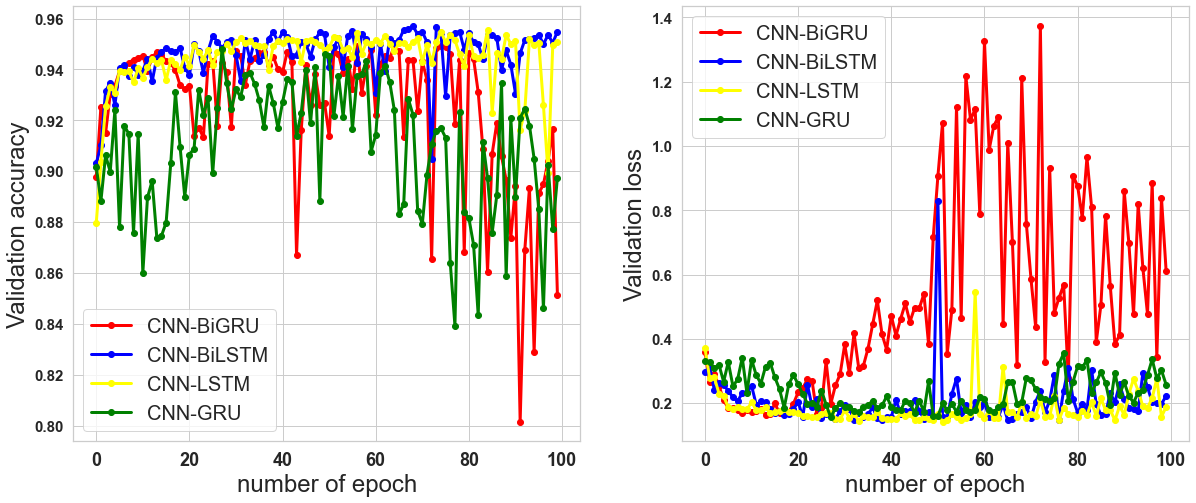

In [37]:
model_all_evaluate(CBIGRU_history, CBILSTM_history,CLSTM_history, CGRU_history )

In [40]:
CBigru = load_model(model_path+"/CBIGRU.h5")
CBilstm = load_model(model_path+"/CBILSTM.h5")
Clstm = load_model(model_path+"/CLSTM.h5")
Cgru = load_model(model_path+"/CGRU.h5")
MLA = {
     'CNN-BiRU' : CBigru,
     'CNN-BiLSTM' : CBilstm,
     'CNN-LSTM' : Clstm,
     'CNN-GRU' : Cgru, 
}
columns = []
hybrid_compare = pd.DataFrame(columns = columns)
# n_classes=4
model = load_model(model_path+"/CBIGRU.h5")
predictions = model.predict(test_padded)
y_pred = np.argmax(predictions, axis=1)
evaluation = model.evaluate(test_padded,y_test)
print('loss {}'.format(evaluation[0]))
print('Accuracy {}'.format(evaluation[1]))
print('Precision {}'.format(precision_score(y_test, y_pred , average="macro")))
print('Recall {}'.format(recall_score(y_test, y_pred , average="macro")))
print('f1 score {}'.format(f1_score(y_test, y_pred , average="macro")))
row_index = 0
for name,alg in MLA.items():
    MLA_name = name
    evaluation = alg.evaluate(test_padded,y_test)
    y_pred = alg.predict(test_padded)
    y_pred = np.argmax(y_pred, axis=1)
    weighted_averaged_recall = recall_score(y_test, y_pred , average="macro")
    weighted_averaged_precision = precision_score(y_test, y_pred , average="micro")

    weighted_averaged_f1 = 2*((weighted_averaged_recall*weighted_averaged_precision)/(weighted_averaged_recall+weighted_averaged_precision))
    hybrid_compare.loc[row_index,'Name'] = MLA_name
    hybrid_compare.loc[row_index, 'Accuracy'] = evaluation[1]
    hybrid_compare.loc[row_index, 'loss'] = evaluation[0]
    hybrid_compare.loc[row_index, 'Precision'] = weighted_averaged_precision
    hybrid_compare.loc[row_index, 'Recall'] = weighted_averaged_recall
    hybrid_compare.loc[row_index, 'F1 Score'] = weighted_averaged_f1
   

    row_index+=1
    
hybrid_compare.sort_values(by = ['Accuracy'], ascending = False, inplace = True)    
hybrid_compare

1345/1345 [==============================] - 18s 13ms/step - loss: 0.3724 - accuracy: 0.9490
loss 0.37238290905952454
Accuracy 0.9489688873291016
Precision 0.9578450594280671
Recall 0.806618828415695
f1 score 0.8537570349170919
1345/1345 [==============================] - 9s 6ms/step - loss: 0.1464 - accuracy: 0.9487


,Name,Accuracy,loss,Precision,Recall,F1 Score
1,CNN-BiLSTM,0.955107,0.214488,0.955107,0.853579,0.901493
2,CNN-LSTM,0.954293,0.146695,0.954293,0.846571,0.897210
0,CNN-BiRU,0.948969,0.372383,0.948969,0.806619,0.872023
3,CNN-GRU,0.948736,0.146361,0.948736,0.866643,0.905833
